In [14]:
# %pip install pandas
# %pip install selenium
# %pip install Pyarrow

In [15]:
# Import necessary libraries
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.actions.wheel_input import ScrollOrigin
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import re
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
import os
load_dotenv()
pass

### Price Scraping Function


def wait_for_page_load(browser, timeout=10):   
    """Wait for the page to load by checking the document.readyState.""" 
    WebDriverWait(browser, timeout).until(
        lambda x: x.execute_script("return document.readyState") == "complete"
    )


def find_element_by_text(text, tag='li', browser=None, wait=None, timeout=10):
    """
    Find an element by its text content.
    
    Args:
        text (str): The text content to look for.
        tag (str): The tag name to filter (default is 'li').
        browser (webdriver): The browser instance to use.
        wait (WebDriverWait): The WebDriverWait instance.
        timeout (int): Timeout period for waiting.

    Returns:
        WebElement or None: The found element or None if not found.
    """
    # Construct an XPath expression to find the tag with the specific text
    xpath = f"//{tag}[text()='{text}']"

    # Wait until the desired element is located or time out
    try:
        element = wait.until(EC.presence_of_element_located((By.XPATH, xpath)))
        return element
    except Exception as e:
        print(f"Element with text '{text}' not found. Error: {e}")
        return None


def extract_product_info(store_name, browser, wait):
    """Extract information about a product from a store page."""
    
    wait_for_page_load(browser)
    time.sleep(5)
    
    li_elements = browser.find_elements(By.TAG_NAME, "li")
    
    product_info_list = []
    product_names = []
    product_prices = []
    
    for li_elt in li_elements:  # Loop through each category
        if (li_elt.find_elements(By.TAG_NAME, "h3")  # Check if it contains food items and is not Featured Items
            and li_elt.find_elements(By.TAG_NAME, "h3")[0].text != "Artículos destacados" 
            and li_elt.find_elements(By.TAG_NAME, "h3")[0].text != "Featured items"):
            
            category = li_elt.find_elements(By.TAG_NAME, "h3")[0].text
            
            # Locate all matching elements using Selenium's find_elements
            span_elements = li_elt.find_elements(By.TAG_NAME, "span")
            price_pattern = r"^(USD ?|\$ ?)\d+\.\d{2}$"
            review_pattern = r" \d+% \((\d+)\)"
                        
            for index, element in enumerate(span_elements):
                price = element.text
                calories = None
                rating_percentage = None
                num_reviews = 0
                
                # Check if the current text begins with "USD" or "$"
                if price.startswith("USD") or price.startswith("$"):
                    if not re.match(price_pattern, price):  # Check if the str matches the price pattern
                        continue
                    
                    # Convert price to float
                    # Adjust for inflated delivery prices (ranges from 10-30% depending on the store so assume 20%)
                    if price.startswith("USD "): 
                        price = round(float(price[4:]) / 1.2, 2)
                    else:
                        price = round(float(price[4:]) / 1.2, 2)
                    
                    # Get the previous element's text (if it exists)
                    product_name = span_elements[index - 1].text if index > 0 else None
                    
                    # Avoid duplicate products 
                    if product_name in product_names:  # Skip if product name and price match 
                        index = product_names.index(product_name)
                        if price == product_prices[index]:
                            continue
                    
                    product_names.append(product_name)
                    product_prices.append(price)
                        

                    # Check if the next element is ' • \n'
                    if index + 1 < len(span_elements) and span_elements[index + 1].text.strip() == '•':
                        
                        if not re.match(review_pattern, span_elements[index + 2].text):
                            rating_percentage = None
                            num_reviews = 0
                            calories = int(span_elements[index + 2].text.split()[0])
                        else:
                            # Get the next-next element's text
                            reviews = span_elements[index + 2].text if index + 2 < len(span_elements) else None

                            # Parse the reviews text
                            reviews_split = reviews.split()
                            rating_percentage = float(reviews_split[0][:-1])
                            num_reviews = int(reviews_split[1][1:-1])
                            
                            if index + 3 < len(span_elements) and span_elements[index + 3].text.strip() == '•':
                                calories = int(span_elements[index + 4].text.split()[0])
                        
                        product_info_list.append([store_name, category, product_name, price, rating_percentage, num_reviews, calories])
                    else:
                        product_info_list.append([store_name, category, product_name, price, None, 0, None])
            
    return product_info_list


def product_scraper(search_query, location, max_stores=50, file_storage=None, file_name=None, headless=True):
    """Scrape the prices of food products based on a search question and location.
    
    Parameters:
        search_question (str): The search question to look for.
        location (str): The location to search in.
        file_storage (str): The method of storing the files as CSV. Options: None, "individual", "combined", "both".
        file_name (str): The name of the file to store the data in as CSV. Must include if file_storage is not None.
        headless (bool): Whether to run the browser in headless mode.
    
    Returns:
        pandas.DataFrame: A DataFrame containing the information about the products found.
    """
    
    # Check the input parameters
    if max_stores < 1:
        raise ValueError("max_stores must be greater than 0.")
    if type(search_query) != str:
        raise TypeError("search_query must be a string.")
    if type(location) != str:
        raise TypeError("location must be a string.")
    if file_storage not in [None, "individual", "combined", "both"]:
        raise ValueError("file_storage must be None, 'individual', 'combined', or 'both'.")
    if file_storage and type(file_name) != str:
        raise TypeError("file_name must be a string.")
    if file_name and not file_storage:
        raise ValueError("file_name must be included if file_storage is not None.")
    if file_storage and not file_name:
        raise ValueError("file_name must be included if file_storage is not None.")
    if file_name:
        if file_name.split(".")[-1] == "csv":
            file_name = ".".join(file_name.split(".")[:-1])
            
    # Initialize a `tqdm` object with a total of 10
    setup_bar = tqdm(total=4, desc="Setting up the browser...")
            
    # Set up the browser
    options = Options()
    if headless:
        options.add_argument("--headless")
    
    browser = webdriver.Chrome(options=options)
    wait = WebDriverWait(browser, 10)
    english = True

    # Get the website URL from the environment variables
    website_url = os.getenv("WEBSITE_URL")

    # Open the specific website
    browser.get(website_url)

    # Check if the page is in English or Spanish
    search_bar = browser.find_element(By.XPATH, '//*[@role="combobox"]')
    placeholder = search_bar.get_attribute('placeholder')
    if placeholder == "Ingresa la dirección de entrega":
        english = False

    setup_bar.update(1)

    # Search bar for the location
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@role="combobox"]')))
        
    # Using XPath to select elements based on the role attribute
    combobox_elements = browser.find_elements(By.XPATH, '//*[@role="combobox"]')

    # Access the first found combobox element
    if combobox_elements:
        search_bar = combobox_elements[0]
        
        # Input the search term into the search bar
        search_bar.send_keys(location)
        time.sleep(1)
        
        # Press "Enter" to trigger the search
        search_bar.send_keys(Keys.RETURN)
    else:
        raise Exception("First search bar not found.")

    # Wait for the page to load
    # TODO: Find a more robust way to wait for the page to load
    time.sleep(3)
    wait_for_page_load(browser)
    time.sleep(3)
    
    setup_bar.update(1)

    # Second search bar for the search term
    combobox_elements = browser.find_elements(By.XPATH, '//*[@role="combobox"]')
    span_elements = browser.find_elements(By.TAG_NAME, 'span')
    span = False

    # Access the first found combobox element
    if combobox_elements:
        search_bar = combobox_elements[0]
        
        # Input the search term into the search bar
        search_bar.click()
        time.sleep(1)
    elif span_elements:  # Handles the case where the search bar is not a combobox
        search_bar = span_elements[0]
        
        # Input the search term into the search bar
        search_bar.click()
        time.sleep(1)
        span = True
    else:
        raise Exception("Second search bar not found.")

    # Search for restaurants
    if english:  # Check if the language is set to English
        restaurant_tab = find_element_by_text('Restaurants', tag='li', browser=browser, wait=wait)
    else:
        restaurant_tab = find_element_by_text('Restaurantes', tag='li', browser=browser, wait=wait)

    if restaurant_tab:
        restaurant_tab.click()
        time.sleep(1)

    # Input the search term into the search bar
    search_bar = browser.find_element(By.XPATH, '//*[@role="combobox"]')
    search_bar.send_keys(search_query)
    search_bar.send_keys(Keys.RETURN)
    
    setup_bar.update(1)

    time.sleep(3)
    wait_for_page_load(browser)

    main_url = browser.current_url  # Get the main URL to return to after visiting each store
    store_names = []  # Store previous store names to avoid duplicates
    all_stores_info_list = []  # Store all store information

    # Get the list of stores to get the number of stores to iterate through
    stores_list = browser.find_elements(By.TAG_NAME, 'h3')
    
    if len(stores_list) < max_stores:
        max_stores = len(stores_list)
        
    setup_bar.update(1)
    
    # Close the processing bar after processing is complete
    setup_bar.close()
    
    processing_bar = tqdm(total=max_stores, desc="Extraction Phase")
    
    for i in range(max_stores):  # Loop through each store
        # Update the processing_bar
        processing_bar.update(1)
        
        # Wait for the h3 element to be present
        wait.until(EC.presence_of_element_located((By.TAG_NAME, 'h3')))
        
        # Get the list of h3 elements again
        stores_list = browser.find_elements(By.TAG_NAME, 'h3')
        
        # Get the next h3 element to click on
        store = stores_list[i]
        store_name = store.text
        
        # Skip if the h3 element is empty or if it is a duplicate
        if store_name == '' or store_name in store_names:
            continue
        
        store_names.append(store_name)
        
        # Scroll to make the element visible in the viewport
        ActionChains(browser).move_to_element(store).perform()

        try:  # Handle cases where the store is intercepted by a popup
            store.click()
        except Exception as e:
            ActionChains(browser).move_to_element(store).scroll_by_amount(0, 100).perform()
            try:
                store.click()
            except Exception as e:
                print(f"_____\nError clicking on store: {store_name}\nIteration: {i, len(store_names)}\nError: {e}\n_____")
                break  # Change this to continue once bug is fixed
        
        # Extract information about the store
        store_product_info_list = extract_product_info(store_name, browser, wait)
        
        # Save the store information to a CSV file
        if file_storage == "individual" or file_storage == "both":
            try:  # Handle cases when it might overwrite a file
                # Create a DataFrame from the product info
                store_df = pd.DataFrame(store_product_info_list, columns=['Store Name', 'Category', 'Product Name', 'Price', 'Rating', 'Number of Reviews', 'Calories'])

                # Save the DataFrame to a CSV file with UTF-8 encoding
                store_df.to_csv(f"pricing files/{file_name}_{store_name}.csv", index=False, encoding="utf-8")
            except Exception as e:
                print(f"Error saving store information to CSV for {store_name}: {e}")
        
        all_stores_info_list.extend(store_product_info_list)
        
        time.sleep(3)
        browser.back()
        
        # Handle cases where the browser does not return to the main URL
        if browser.current_url != main_url:
            print(f"_____\nError returning to main URL for {store_name}\nIteration: {i, len(store_names)}\nURL: {browser.current_url}\n_____")
            browser.get(main_url)
            time.sleep(3)
        
    # Create a DataFrame from the product info
    all_stores_df = pd.DataFrame(all_stores_info_list, columns=['Store Name', 'Category', 'Product Name', 'Price', 'Rating', 'Number of Reviews', 'Calories'])

    if file_storage == "combined" or file_storage == "both":
        try:  # Handle cases when it might overwrite a file
            # Save the DataFrame to a CSV file with UTF-8 encoding
            all_stores_df.to_csv(f"pricing files/{file_name}.csv", index=False, encoding="utf-8")
        except Exception as e:
            print(f"Error saving all store information to CSV: {e}")
            
    # Close the browser
    browser.quit()
    
    # Close the progress bar after completing all tasks
    processing_bar.close()

    return all_stores_df


In [16]:
import companalysis as ca

search_query = "coffee shops"
# location = "1524 Sunset Blvd, Los Angeles, CA 90026, United States"  # Echo Park
location = "941 Westwood Blvd, Los Angeles, CA 90024, USA"  # Westwood
max_stores = 1000
file_storage = "combined"
file_name = "product_dataset"
headless = True

final_stores_df = ca.product_scraper(search_query, location, max_stores=max_stores, file_storage=file_storage, file_name=file_name, headless=headless)


Setting up the browser...:  25%|██▌       | 1/4 [00:09<00:29,  9.83s/it]

KeyboardInterrupt: 

In [ ]:
store_counts = final_stores_df["Store Name"].value_counts()

In [ ]:
store_counts.index[-10:]

Index(['Quackadoodle Country Boy Chicken', 'The Waffle', 'House of Pies',
       'Kreation Organic Juicery (Westwood)', 'Tribal Cafe',
       'The Coffee Bean & Tea Leaf (11913 W Olympic Blvd)',
       'Blueys Santa Monica', 'Nature's Brew by Bacari',
       'Taco Bell (10937 Weyburn Ave.)', 'Marmalade Cafe - Sherman Oaks'],
      dtype='object', name='Store Name')

In [ ]:
final_stores_df["Product Name"]

0                             Berry Pot
1                           Granola Cup
2                  Keen Greens Smoothie
3       Protein PB & Blueberry Smoothie
4                        Almond Oatmeal
                     ...               
5315                        Latte glass
5316                  Cap "sipp caffee"
5317                 Mac & Cheese Bites
5318                        Wedge Salad
5319         Chicken Fettuccine Alfredo
Name: Product Name, Length: 5320, dtype: object

In [ ]:
final_stores_df = pd.read_csv("pricing files/product_dataset.csv")

In [ ]:
final_stores_df['Product Name'] = final_stores_df["Product Name"].to_string()
product_names = final_stores_df["Product Name"].values

In [17]:
import re
from collections import Counter

# Provided dataset
final_stores_df['Product Name'] = final_stores_df["Product Name"].to_string()
product_names = final_stores_df["Product Name"].values

# The keywords to check for
keywords = [
    "brownie", "cookie", "ice cream", "gelato", "cake", "mousse", "pie",
    "tiramisu", "cheesecake", "pudding", "macaron", "cupcake", "torte",
    "trifle", "parfait", "sundae", "eclair", "fudge", "donut", "waffle",
    "custard", "macaroon", "pastry", "baklava", "popsicle", "sorbet",
    "creme brulee", "tart", "flan", "mille-feuille", "strudel", "crumble",
    "beignet", "profiterole", "babka", "crepes", "frozen yogurt", "mochi",
    "bread pudding", "sticky toffee pudding", "rice pudding", "churro",
    "pavlova", "meringue", "fruit tart", "marzipan", "nougat", "fondant",
    "truffle", "blondie", "cannoli", "fritter", "gummy", "praline",
    "snowball", "rock candy", "marshmallow", "brandy snap", "banana split",
    "s'more", "sweet", "gâteau", "sacher torte", "brandy pudding",
    "kouign amann", "panettone", "panforte", "pandoro", "chocotorta",
    "rogel", "nanaimo bar", "pizzelle", "zeppole", "croquembouche", "millefoglie",
    "cassata", "gugelhupf", "rosette", "jalebi", "kulfi", "gajar halwa",
    "malva pudding", "melktert", "lamington", "butter tart", "anpan",
    "snickerdoodle", "bars", "biscotti", "blondies", "brownies", "cannolis",
    "churros", "cobbler", "cookies", "crisps", "crumbles", "cupcakes",
    "doughnuts", "eclairs", "fritters", "gingerbread", "jelly",
]

# Normalize and tokenize the dataset
normalized_names = [re.sub(r'[^\w\s]', '', name.lower()) for name in product_names]
all_words = ' '.join(normalized_names).split()

# Initialize a Counter object to count keyword occurrences
keyword_counter = Counter()

# Count each keyword
for keyword in keywords:
    keyword_counter[keyword] = all_words.count(keyword.lower())

# Display the results
print(dict(keyword_counter))

keyword_keys = np.array(list(dict(keyword_counter).keys()))
keyword_counts = np.array(list(dict(keyword_counter).values()))

print(keyword_counts.sum())

KeyboardInterrupt: 

In [ ]:
print(len(keywords))
print(len(np.unique(keywords)))
print(len(keyword_keys))
print(keyword_keys)

64
64
64
['pasta' 'salad' 'pizza' 'burger' 'soup' 'sandwich' 'taco' 'steak'
 'burrito' 'wrap' 'sushi' 'noodles' 'lasagna' 'omelet' 'quesadilla'
 'curry' 'stew' 'brisket' 'risotto' 'fajita' 'gnocchi' 'ravioli' 'paella'
 'bolognese' 'fillet' 'tender' 'fettuccine' 'tortilla' 'frittata'
 'tostada' 'panini' 'carbonara' 'chimichurri' 'ceviche' 'stir-fry'
 'parmigiana' 'alfredo' 'meatloaf' 'shakshuka' 'poke' 'tikka' 'falafel'
 'pilaf' 'tagine' 'poutine' 'ramen' 'pancake' 'filet' 'kabob' 'enchilada'
 'chicken' 'beef' 'pork' 'fish' 'shrimp' 'carne' 'pollo' 'cerdo' 'pescado'
 'boeuf' 'porc' 'torte' 'ensalada' 'suppe']


In [ ]:
# dessert_keywords = np.array(keyword_keys)[keyword_counts > 0]
# np.save("dessert_keywords.npy", dessert_keywords)

In [ ]:
# dessert_keywords = np.array(keywords)[keyword_counts > 0]
# np.save("dessert_keywords.npy", dessert_keywords)

In [ ]:
# drink_keywords = np.array(keywords)[keyword_counts > 0]
# np.save("drink_keywords.npy", drink_keywords)

In [ ]:
len(drink_keywords)

43

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of filtered keywords
num_keywords = len(keywords)

# Create a list of x-axis values
x_values = np.arange(num_keywords)

# Create a list of counts for each number of occurrences
occurrence_counts = np.array([(keyword_counts > x).sum() for x in x_values])


In [ ]:
print(num_keywords)

63


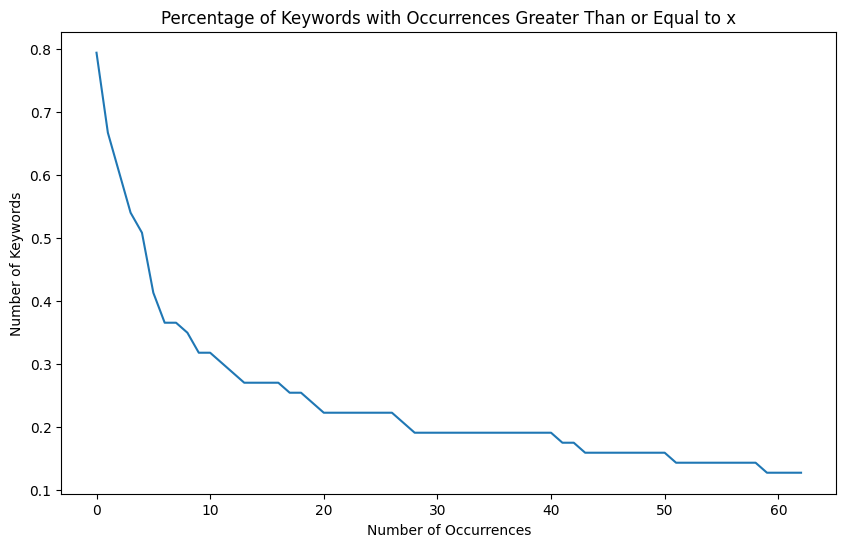

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, occurrence_counts / num_keywords)
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Keywords')
plt.title(f'Percentage of Keywords with Occurrences Greater Than or Equal to x')
plt.show()


In [ ]:
list(set(filtered_words))[2000:]

['rugelach',
 'chiquito',
 'mesquite',
 'group',
 'mountain',
 'mm',
 'duo',
 'halva',
 'crudités',
 'couscous',
 'noodles',
 'ciabatta',
 '5',
 'honey',
 'cheeto',
 'grains',
 'mad',
 'sugar',
 'ocean',
 'avotlt',
 'enhancedelectro',
 'hair',
 'xlarge',
 'crunch',
 'barbeque',
 'ribeye',
 '1969',
 'cubana',
 'greek',
 'culture',
 'anchovy',
 'vegetable',
 'tumeric',
 'pickles',
 'canned',
 'incredible',
 'ny',
 'featured',
 'hydrate',
 'medium',
 'skinnyburger',
 'riptide',
 'jalapeno',
 'dog',
 'shake',
 'sausage',
 'browns',
 'works',
 'straus',
 'cuban',
 'marble',
 'plate',
 'refreshertropical',
 'good',
 'turmeric',
 'two',
 'allegra',
 'licious',
 'piece',
 'earthbites',
 'aqua',
 'draught',
 'garden',
 'gallo',
 'quiches',
 'spice',
 'scone',
 'stew',
 'wild',
 'misto',
 'l',
 'earl',
 'rico',
 'mozzarella',
 'pc',
 'dijon',
 'olive',
 'cocoa',
 'meat',
 'longevity',
 '24oz',
 'wing',
 'redskinned',
 'wings',
 'rancheros',
 'seasonal',
 'waffle',
 'magic']

In [ ]:
store_counts.values

array([173, 168, 154, 154, 152, 149, 141, 140, 139, 138, 138, 129, 127,
       119, 117, 114, 108, 108, 105,  97,  96,  96,  94,  90,  85,  83,
        83,  81,  80,  79,  76,  75,  72,  70,  69,  65,  60,  60,  57,
        55,  54,  54,  53,  52,  50,  49,  45,  45,  45,  44,  44,  43,
        42,  41,  37,  37,  37,  36,  35,  33,  32,  30,  26,  25,  24,
        23,  20,  19,   9,   7,   5,   4,   4,   4,   4,   3,   3,   3,
         3], dtype=int64)

In [ ]:
store_counts = final_stores_df['Store Name'].value_counts(sort=False)
print(store_counts)


Store Name
Insomnia Cookies (945 Westwood Boulevard)    54
Bluestone Lane Coffee - Westwood Blvd        89
Meet Fresh - Westwood                        73
Name: count, dtype: int64


In [ ]:
final_stores_df

,Store Name,Category,Product Name,Price,Rating,Number of Reviews,Calories
0,Insomnia Cookies (945 Westwood Boulevard),Boxes,6-pack,17.71,93.0,122,NaN
1,Insomnia Cookies (945 Westwood Boulevard),Boxes,Deluxe 4-pack,19.79,100.0,17,NaN
2,Insomnia Cookies (945 Westwood Boulevard),Boxes,Super 6,19.38,88.0,17,NaN
3,Insomnia Cookies (945 Westwood Boulevard),Boxes,4+4-pack,30.21,100.0,9,NaN
4,Insomnia Cookies (945 Westwood Boulevard),Boxes,12-pack,32.29,92.0,40,NaN
...,...,...,...,...,...,...,...
211,Meet Fresh - Westwood,SMALL BITES,Q Mochi & Caramel Pudding Combo,5.21,100.0,9,NaN
212,Meet Fresh - Westwood,SMALL BITES,Q Mochi & Almond Pudding Combo,5.21,90.0,11,NaN
213,Meet Fresh - Westwood,SMALL BITES,Red Bean Almond Pudding,2.71,91.0,12,NaN
214,Meet Fresh - Westwood,SMALL BITES,Boba Caramel Pudding,2.71,100.0,13,NaN


In [2]:
import pandas as pd
all_stores = pd.read_csv("pricing files/product_dataset.csv")["Store Name"].unique()

In [3]:
len(all_stores)

79